In [5]:
!pip install prophet

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## 1. Load dataset

In [7]:
def import_data():
  raw_data_df = pd.read_csv("/content/MAC002163.csv", header=0)
  return raw_data_df

In [8]:
result = import_data()

In [9]:
result.head()

,LCLid,stdorToU,DateTime,KWH/hh (per half hour)
0,MAC002163,Std,2013-01-15 15:30:00.0000000,0.775
1,MAC002163,Std,2013-01-15 16:00:00.0000000,1.3609999
2,MAC002163,Std,2013-01-15 16:30:00.0000000,0.325
3,MAC002163,Std,2013-01-15 17:00:00.0000000,0.179
4,MAC002163,Std,2013-01-15 17:30:00.0000000,0.51


In [10]:
result['Date'] = pd.to_datetime(result['DateTime'])
result['KWH/hh'] = pd.to_numeric(result['KWH/hh (per half hour)'], downcast='float',errors='coerce') #raise
data = result[['Date','KWH/hh']]

In [11]:
data.head()

,Date,KWH/hh
0,2013-01-15 15:30:00,0.775
1,2013-01-15 16:00:00,1.361
2,2013-01-15 16:30:00,0.325
3,2013-01-15 17:00:00,0.179
4,2013-01-15 17:30:00,0.510


In [12]:
data.describe()

,KWH/hh
count,29661.000000
mean,0.623433
std,0.518608
min,0.059000
25%,0.139000
50%,0.574000
75%,0.903000
max,4.053000


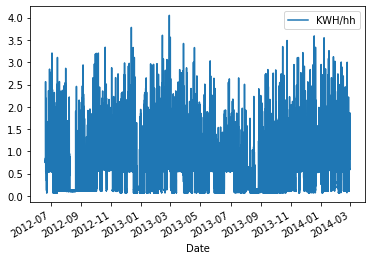

In [13]:
data.plot(x='Date', y='KWH/hh')
plt.show()

# 1.1 Resampling

In [14]:
indexed = data.set_index('Date')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


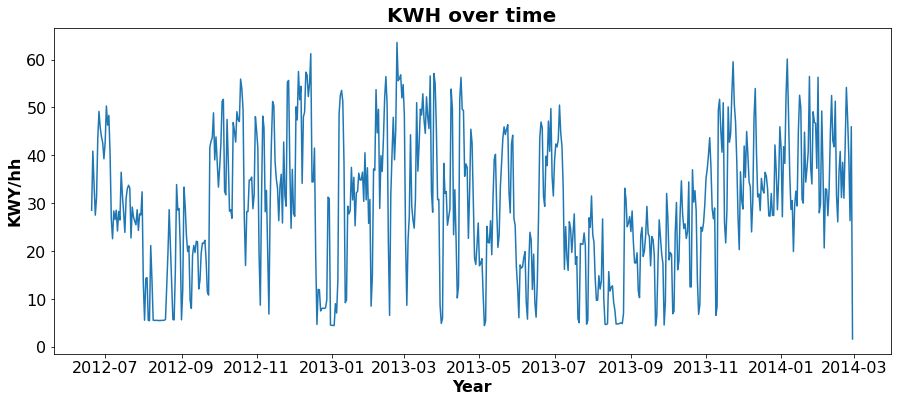

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))
daily = indexed.resample('D').sum()
sns.lineplot(daily.index, daily['KWH/hh'] )

ax.set_title('KWH over time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('KWY/hh', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


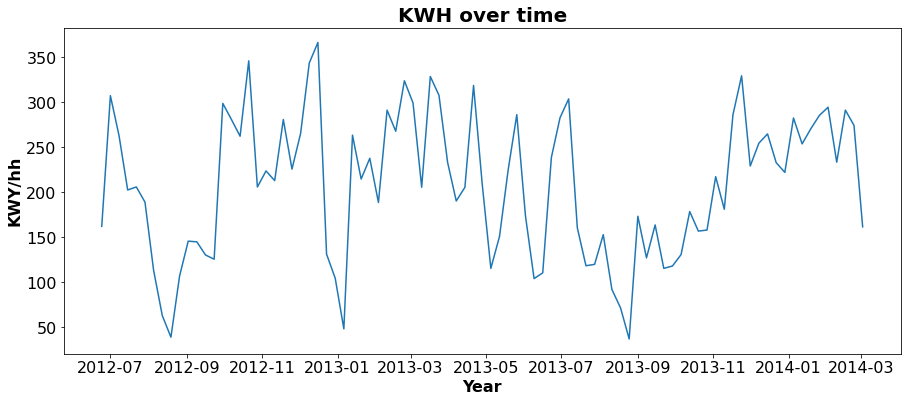

In [16]:
weekly = indexed.resample('W').sum()
fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(weekly.index, weekly['KWH/hh'] )

ax.set_title('KWH over time', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Year', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('KWY/hh', fontsize = 16, fontdict=dict(weight='bold'))
plt.tick_params(axis='y', which='major', labelsize=16)
plt.tick_params(axis='x', which='major', labelsize=16)
plt.show()

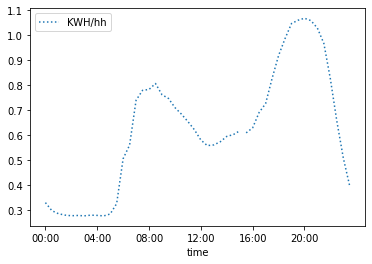

In [17]:
by_time = indexed.groupby(indexed.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks = hourly_ticks, style=[':', '--', '-'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'KWH/hh')

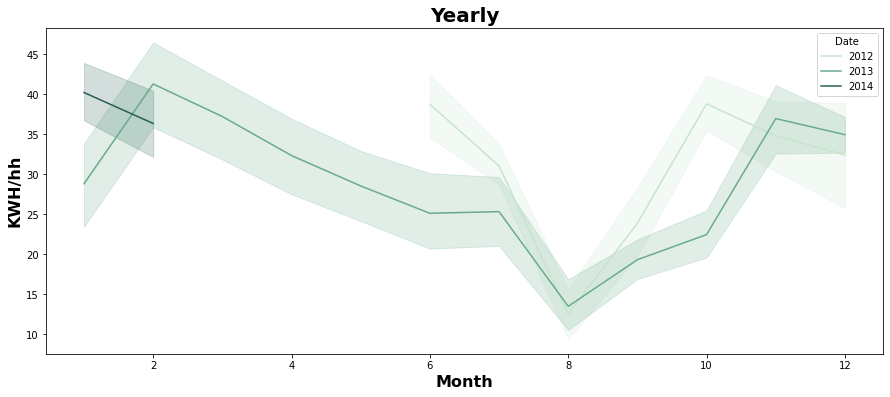

In [18]:
variable = 'KWH/hh'
fig, ax = plt.subplots(figsize=(15, 6))

palette = sns.color_palette("ch:2.5,-.2,dark=.3", 3)
sns.lineplot(daily.index.month, daily[variable], hue=daily.index.year, palette=palette)
ax.set_title('Yearly', fontsize = 20, loc='center', fontdict=dict(weight='bold'))
ax.set_xlabel('Month', fontsize = 16, fontdict=dict(weight='bold'))
ax.set_ylabel('KWH/hh', fontsize = 16, fontdict=dict(weight='bold'))

# 2. Modeling with Prophet
The Date column must be called ‘ds’ and the value column we want to predict ‘y’. Daily summary data is used in the example below.

In [19]:
df = daily
df.reset_index(inplace=True)
df = df.rename(columns={'Date':'ds', 'KWH/hh':'y'})
df.head()

,ds,y
0,2012-06-20,28.541000
1,2012-06-21,40.884998
2,2012-06-22,33.806999
3,2012-06-23,27.506001
4,2012-06-24,31.191000


In [20]:
import prophet

In [21]:
df_prophet = prophet.Prophet(changepoint_prior_scale=0.1, yearly_seasonality=True)
df_prophet.fit(df)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
df_forecast = df_prophet.make_future_dataframe(periods=30*2, freq='D')
df_forecast = df_prophet.predict(df_forecast)

Text(0.5, 1.0, 'Predictions')

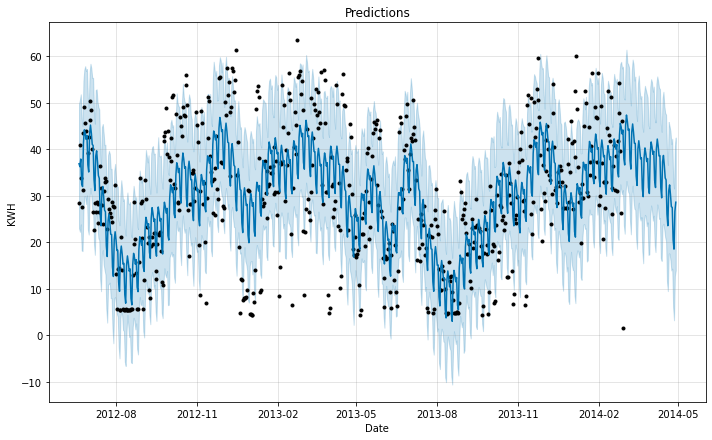

In [23]:
df_prophet.plot(df_forecast, xlabel='Date', ylabel='KWH')
plt.title('Predictions')

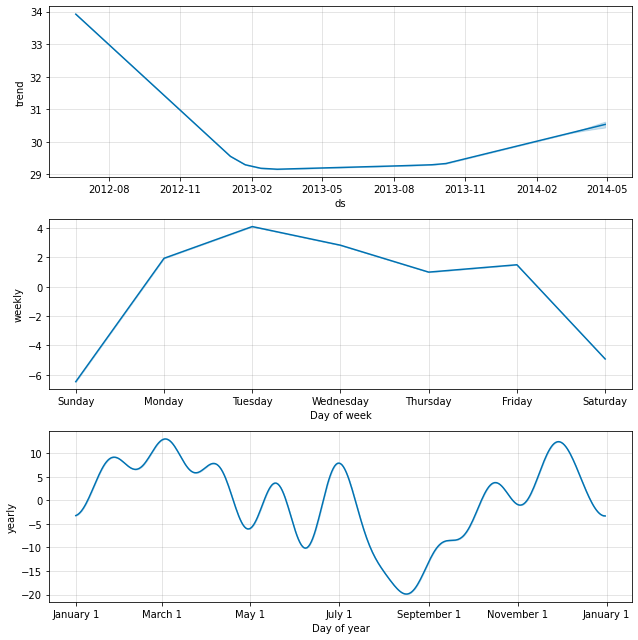

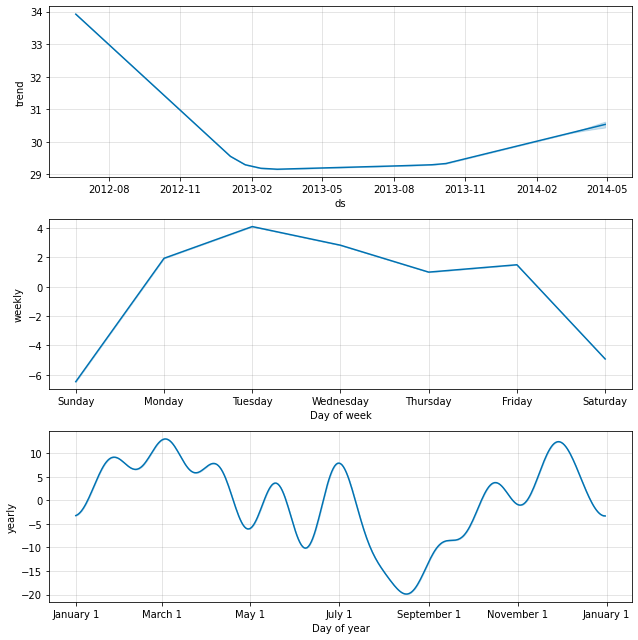

In [24]:
df_prophet.plot_components(df_forecast)


In [25]:
import pickle
with open('forecast_model.pckl', 'wb') as fout:
    pickle.dump(df_prophet, fout)